In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
test = pd.read_csv(r"D:\PA\NBA_Data\season_2021_detailed.csv")
test.head()

,date,team,player,role,MP,FG,FGA,FG_PCT,FG3,FG3A,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS
0,2020-12-22T19:00:00,Brooklyn Nets,Tyler Johnson,Reserve,5.083333,0,1,0.000,0,0,...,1,0,1,0,1,0,0,0,0,-12.0
1,2020-12-22T19:00:00,Brooklyn Nets,Kyrie Irving,Starter,25.416667,10,16,0.625,4,7,...,1,3,4,4,0,0,1,3,26,32.0
2,2020-12-22T19:00:00,Brooklyn Nets,Kevin Durant,Starter,24.400000,7,16,0.438,1,2,...,1,4,5,3,3,1,1,3,22,26.0
3,2020-12-22T19:00:00,Brooklyn Nets,Joe Harris,Starter,20.333333,4,8,0.500,2,5,...,2,5,7,2,0,1,2,2,10,21.0
4,2020-12-22T19:00:00,Brooklyn Nets,Spencer Dinwiddie,Starter,19.316667,2,6,0.333,1,3,...,0,5,5,4,0,0,3,1,9,24.0


In [3]:
# Group by team and date (i.e. one entry per team per game)
team_game_3s = test.groupby(['date', 'team'])['FG3'].sum().reset_index(name='team_3PM')

# Calculate average across all team-games
average_team_3PM = team_game_3s['team_3PM'].mean()

print(f"Durchschnittlich trifft ein Team {average_team_3PM:.2f} Dreier pro Spiel.")



Durchschnittlich trifft ein Team 12.68 Dreier pro Spiel.


In [4]:
import os
import glob
import pandas as pd

# Folder where your files are stored
folder_path = r"D:\PA\NBA_Data"
detailed_files = glob.glob(os.path.join(folder_path, 'season_*_detailed.csv'))

monthly_stats = []

for file in detailed_files:
    print(f"🔄 Processing: {os.path.basename(file)}")
    try:
        df = pd.read_csv(file)

        # Ensure required columns exist
        required_cols = {'date', 'team', 'FG3', 'FGA', 'FTA', 'TOV', 'ORB'}
        if not required_cols.issubset(df.columns):
            print(f"⚠️ Skipping {file} — missing columns: {required_cols - set(df.columns)}")
            continue

        # Clean up
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df[['FG3', 'FGA', 'FTA', 'TOV', 'ORB']] = df[['FG3', 'FGA', 'FTA', 'TOV', 'ORB']].apply(pd.to_numeric, errors='coerce')
        df.dropna(subset=['date'], inplace=True)

        # ✅ Step 1: Sum up stats per team per game
        game_totals = df.groupby(['date', 'team'])[['FG3', 'FGA', 'FTA', 'TOV', 'ORB']].sum().reset_index()
        game_totals['month'] = game_totals['date'].dt.to_period('M')

        # Calculate pace proxy
        game_totals['pace_proxy'] = game_totals['FGA'] + 0.44 * game_totals['FTA'] + game_totals['TOV'] - game_totals['ORB']

        # ✅ Step 2: Count how many teams played each date (for num_games)
        teams_per_date = game_totals.groupby('date')['team'].nunique().reset_index()
        teams_per_date['num_games'] = teams_per_date['team']
        teams_per_date['month'] = teams_per_date['date'].dt.to_period('M')

        # ✅ Step 3: Monthly aggregates
        monthly_fg3 = game_totals.groupby('month')[['FG3']].sum().reset_index()
        monthly_pace = game_totals.groupby('month')[['pace_proxy']].sum().reset_index()
        monthly_games = teams_per_date.groupby('month')['num_games'].sum().reset_index()

        # ✅ Step 4: Merge and calculate per-game values
        monthly = pd.merge(monthly_fg3, monthly_pace, on='month')
        monthly = pd.merge(monthly, monthly_games, on='month')
        monthly['FG3_per_game'] = monthly['FG3'] / monthly['num_games']
        monthly['pace_proxy_per_game'] = monthly['pace_proxy'] / monthly['num_games']

        monthly_stats.append(monthly[['month', 'FG3_per_game', 'pace_proxy_per_game']])

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

# Combine all results
result_df = pd.concat(monthly_stats, ignore_index=True)

# 🧩 Fill in missing offseason months for smooth plots
all_months = pd.period_range(result_df['month'].min(), result_df['month'].max(), freq='M')
result_df.set_index('month', inplace=True)
result_df = result_df.reindex(all_months)
result_df.index.name = 'month'
result_df = result_df.reset_index()
result_df['month'] = result_df['month'].astype(str)

# Fill missing values (offseason dips)
result_df[['FG3_per_game', 'pace_proxy_per_game']] = result_df[['FG3_per_game', 'pace_proxy_per_game']].fillna(0)

# 💾 Export to CSV
output_path = os.path.join(folder_path, 'monthly_fg3_with_pace.csv')
result_df.to_csv(output_path, index=False)

print(f"\n✅ Done! Saved to: {output_path}")


🔄 Processing: season_1953_detailed.csv
🔄 Processing: season_1954_detailed.csv
🔄 Processing: season_1955_detailed.csv
🔄 Processing: season_1956_detailed.csv
🔄 Processing: season_1957_detailed.csv
🔄 Processing: season_1958_detailed.csv
🔄 Processing: season_1959_detailed.csv
🔄 Processing: season_1960_detailed.csv
🔄 Processing: season_1961_detailed.csv
🔄 Processing: season_1962_detailed.csv
🔄 Processing: season_1963_detailed.csv
🔄 Processing: season_1964_detailed.csv
🔄 Processing: season_1965_detailed.csv
🔄 Processing: season_1966_detailed.csv
🔄 Processing: season_1967_detailed.csv
🔄 Processing: season_1968_detailed.csv
🔄 Processing: season_1969_detailed.csv
🔄 Processing: season_1970_detailed.csv
🔄 Processing: season_1971_detailed.csv
🔄 Processing: season_1972_detailed.csv
🔄 Processing: season_1973_detailed.csv
🔄 Processing: season_1974_detailed.csv
🔄 Processing: season_1975_detailed.csv
🔄 Processing: season_1976_detailed.csv
🔄 Processing: season_1977_detailed.csv
🔄 Processing: season_1978

In [87]:
import os
import glob
import pandas as pd

# Folder where your files are stored
folder_path = r"D:\PA\NBA_Data"
detailed_files = glob.glob(os.path.join(folder_path, 'season_*_detailed.csv'))

monthly_stats = []

for file in detailed_files:
    print(f"🔄 Processing: {os.path.basename(file)}")
    try:
        df = pd.read_csv(file)

        # Ensure required columns exist
        required_cols = {'date', 'team', 'FG3', 'FG3A', 'AST', 'PTS', 'FGA', 'FTA', 'TOV', 'ORB'}
        if not required_cols.issubset(df.columns):
            print(f"⚠️ Skipping {file} — missing columns: {required_cols - set(df.columns)}")
            continue

        # Clean up
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df[['FG3', 'FG3A', 'AST', 'PTS', 'FGA', 'FTA', 'TOV', 'ORB']] = \
            df[['FG3', 'FG3A', 'AST', 'PTS', 'FGA', 'FTA', 'TOV', 'ORB']].apply(pd.to_numeric, errors='coerce')
        df.dropna(subset=['date'], inplace=True)

        # ✅ Step 1: Sum up stats per team per game
        game_totals = df.groupby(['date', 'team'])[
            ['FG3', 'FG3A', 'AST', 'PTS', 'FGA', 'FTA', 'TOV', 'ORB']
        ].sum().reset_index()

        # Estimate possessions
        game_totals['possessions'] = game_totals['FGA'] + 0.44 * game_totals['FTA'] + game_totals['TOV'] - game_totals['ORB']
        game_totals['month'] = game_totals['date'].dt.to_period('M')

        # ✅ Step 2: Monthly average per team-game (only actual games are included)
        monthly = game_totals.groupby('month')[
            ['FG3', 'FG3A', 'AST', 'PTS', 'possessions']
        ].mean().reset_index()

        # Rename columns for clarity
        monthly.rename(columns={
            'FG3': 'FG3_per_game',
            'FG3A': 'FG3A_per_game',
            'AST': 'AST_per_game',
            'PTS': 'PTS_per_game',
            'possessions': 'possessions_per_game'
        }, inplace=True)

        # Compute 3P%
        monthly['FG3_PCT'] = monthly['FG3_per_game'] / monthly['FG3A_per_game']

        # Collect results
        monthly_stats.append(monthly)

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

# Combine all results
result_df = pd.concat(monthly_stats, ignore_index=True)

# 🧩 Fill in missing offseason months for smooth plots
all_months = pd.period_range(result_df['month'].min(), result_df['month'].max(), freq='M')
result_df.set_index('month', inplace=True)
result_df = result_df.reindex(all_months)
result_df.index.name = 'month'
result_df = result_df.reset_index()
result_df['month'] = result_df['month'].astype(str)

# Fill missing values (offseason dips)
columns_to_fill = ['FG3_per_game', 'FG3A_per_game', 'AST_per_game', 'PTS_per_game', 'FG3_PCT', 'possessions_per_game']
result_df[columns_to_fill] = result_df[columns_to_fill].fillna(0)

print(f"\n✅ Done!")


🔄 Processing: season_1953_detailed.csv
🔄 Processing: season_1954_detailed.csv
🔄 Processing: season_1955_detailed.csv
🔄 Processing: season_1956_detailed.csv
🔄 Processing: season_1957_detailed.csv
🔄 Processing: season_1958_detailed.csv
🔄 Processing: season_1959_detailed.csv
🔄 Processing: season_1960_detailed.csv
🔄 Processing: season_1961_detailed.csv
🔄 Processing: season_1962_detailed.csv
🔄 Processing: season_1963_detailed.csv
🔄 Processing: season_1964_detailed.csv
🔄 Processing: season_1965_detailed.csv
🔄 Processing: season_1966_detailed.csv
🔄 Processing: season_1967_detailed.csv
🔄 Processing: season_1968_detailed.csv
🔄 Processing: season_1969_detailed.csv
🔄 Processing: season_1970_detailed.csv
🔄 Processing: season_1971_detailed.csv
🔄 Processing: season_1972_detailed.csv
🔄 Processing: season_1973_detailed.csv
🔄 Processing: season_1974_detailed.csv
🔄 Processing: season_1975_detailed.csv
🔄 Processing: season_1976_detailed.csv
🔄 Processing: season_1977_detailed.csv
🔄 Processing: season_1978

In [69]:
result_df.head()

,month,FG3_per_game,FG3A_per_game,AST_per_game,PTS_per_game,possessions_per_game,FG3_PCT
0,1952-10,0.0,0.0,0.000000,75.500000,38.300000,0.0
1,1952-11,0.0,0.0,4.452055,84.239726,37.876712,0.0
2,1952-12,0.0,0.0,4.198630,82.993151,37.784932,0.0
3,1953-01,0.0,0.0,4.094937,82.196203,35.020759,0.0
4,1953-02,0.0,0.0,3.923077,81.512821,34.143590,0.0


In [92]:
# Convert 'month' to datetime and extract year + month
result_df['month'] = pd.to_datetime(result_df['month'])
result_df['year'] = result_df['month'].dt.year

# ➕ Three-Point Line Introduced in Oct 1979
result_df['three_point_introduction'] = (result_df['month'] >= pd.Timestamp('1979-10-01')).astype(int)

# ➕ Line Shortened: From Oct 1994 to Sep 1997
result_df['shortened_three_point_line'] = result_df['month'].between(
    pd.Timestamp('1994-10-01'), pd.Timestamp('1997-09-30')
).astype(int)

# ➕ Line Reverted: From Oct 1997 onward
result_df['reverted_three_point_line'] = (result_df['month'] >= pd.Timestamp('1997-10-01')).astype(int)

# ➕ Defensive 3-Second Rule: From Oct 2001 onward
result_df['defensive_three_second_rule'] = (result_df['month'] >= pd.Timestamp('2001-10-01')).astype(int)

# ➕ Curry Era: From Jan 2015 onward (leave as-is if Jan start is intentional)
result_df['curry_era'] = (result_df['month'] >= pd.Timestamp('2015-01-01')).astype(int)


# Offseason: if either points or assists is zero → flag as 1
result_df['off_season'] = np.where(
    (result_df['PTS_per_game'] == 0) | (result_df['AST_per_game'] == 0),
    1,
    0
)

In [93]:
# Ensure month is datetime format and properly sorted
result_df['month'] = pd.to_datetime(result_df['month'])
result_df = result_df.sort_values('month')

# Filter for in-season months only
in_season_df = result_df[result_df['off_season'] == 0].copy()

# Compute 6-month centered rolling average for possessions (only in-season)
in_season_df['possessions_per_game_smooth'] = (
    in_season_df['possessions_per_game']
    .rolling(window=3, center=True)
    .mean()
)

# Merge smoothed values back into the full result_df
result_df = result_df.merge(
    in_season_df[['month', 'possessions_per_game_smooth']],
    on='month',
    how='left'
)


In [94]:
# reorder columns
result_df = result_df[['month', 'year', 'FG3_per_game', 'FG3A_per_game', 'FG3_PCT', 'AST_per_game', 
                       'PTS_per_game','possessions_per_game_smooth', 'three_point_introduction', 
                       'shortened_three_point_line', 'reverted_three_point_line', 
                       'defensive_three_second_rule', 'curry_era', 'off_season']]

In [102]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   month                        826 non-null    datetime64[ns]
 1   year                         826 non-null    int32         
 2   FG3_per_game                 826 non-null    float64       
 3   FG3A_per_game                826 non-null    float64       
 4   FG3_PCT                      826 non-null    float64       
 5   AST_per_game                 826 non-null    float64       
 6   PTS_per_game                 826 non-null    float64       
 7   possessions_per_game_smooth  552 non-null    float64       
 8   three_point_introduction     826 non-null    int32         
 9   shortened_three_point_line   826 non-null    int32         
 10  reverted_three_point_line    826 non-null    int32         
 11  defensive_three_second_rule  826 non-null    

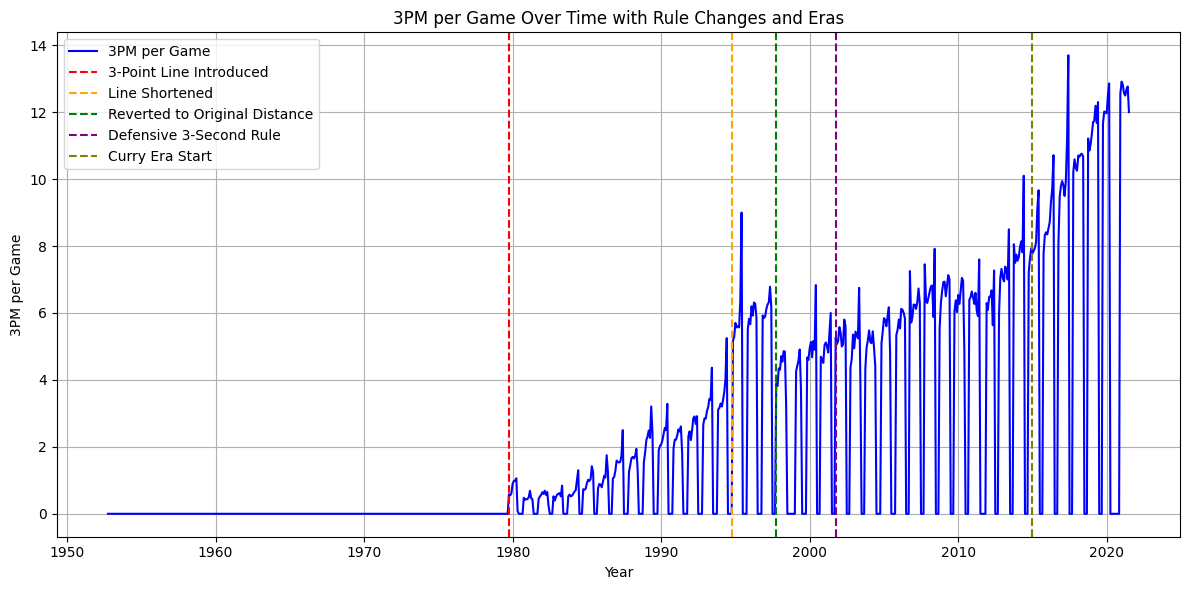

In [104]:
# Filter out rows with 0 or NaN 3PM values


# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=result_df, x='month', y='FG3_per_game', label='3PM per Game', color='blue')

# Rule change markers
plt.axvline(pd.Timestamp('1979-10-01'), color='red', linestyle='--', label='3-Point Line Introduced')
plt.axvline(pd.Timestamp('1994-10-01'), color='orange', linestyle='--', label='Line Shortened')
plt.axvline(pd.Timestamp('1997-10-01'), color='green', linestyle='--', label='Reverted to Original Distance')
plt.axvline(pd.Timestamp('2001-10-01'), color='purple', linestyle='--', label='Defensive 3-Second Rule')
plt.axvline(pd.Timestamp('2015-01-01'), color='olive', linestyle='--', label='Curry Era Start')

# Formatting
plt.title('3PM per Game Over Time with Rule Changes and Eras')
plt.xlabel('Year')
plt.ylabel('3PM per Game')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


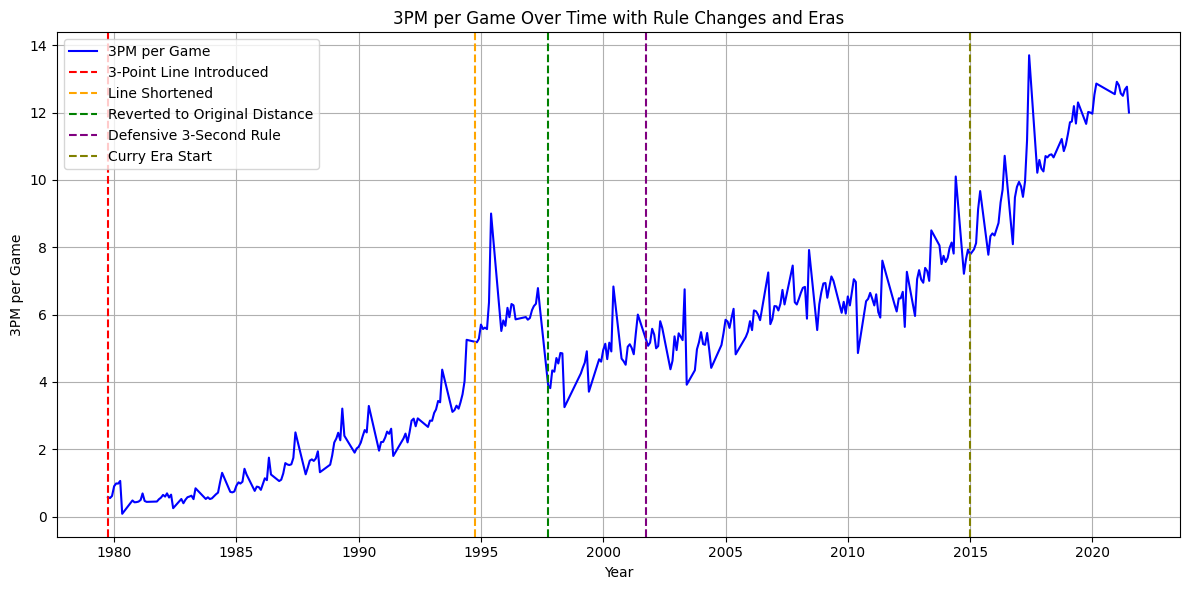

In [105]:
# Filter out rows with 0 or NaN 3PM values
plot_data = result_df[(result_df['FG3_per_game'].notna()) & (result_df['FG3_per_game'] > 0)]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_data, x='month', y='FG3_per_game', label='3PM per Game', color='blue')

# Rule change markers
plt.axvline(pd.Timestamp('1979-10-01'), color='red', linestyle='--', label='3-Point Line Introduced')
plt.axvline(pd.Timestamp('1994-10-01'), color='orange', linestyle='--', label='Line Shortened')
plt.axvline(pd.Timestamp('1997-10-01'), color='green', linestyle='--', label='Reverted to Original Distance')
plt.axvline(pd.Timestamp('2001-10-01'), color='purple', linestyle='--', label='Defensive 3-Second Rule')
plt.axvline(pd.Timestamp('2015-01-01'), color='olive', linestyle='--', label='Curry Era Start')

# Formatting
plt.title('3PM per Game Over Time with Rule Changes and Eras')
plt.xlabel('Year')
plt.ylabel('3PM per Game')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [106]:
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352 entries, 324 to 825
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   month                        352 non-null    datetime64[ns]
 1   year                         352 non-null    int32         
 2   FG3_per_game                 352 non-null    float64       
 3   FG3A_per_game                352 non-null    float64       
 4   FG3_PCT                      352 non-null    float64       
 5   AST_per_game                 352 non-null    float64       
 6   PTS_per_game                 352 non-null    float64       
 7   possessions_per_game_smooth  351 non-null    float64       
 8   three_point_introduction     352 non-null    int32         
 9   shortened_three_point_line   352 non-null    int32         
 10  reverted_three_point_line    352 non-null    int32         
 11  defensive_three_second_rule  352 non-null    int

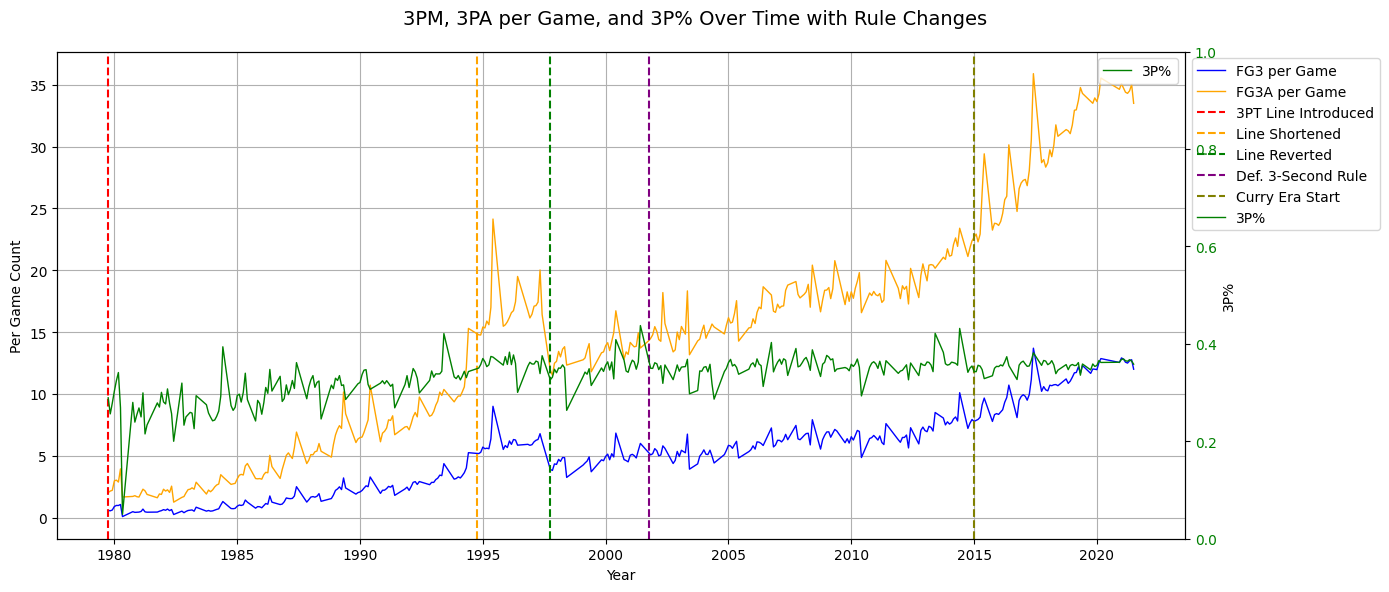

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare the data
plot_data = result_df[(result_df['FG3_per_game'].notna()) & (result_df['FG3_per_game'] > 0)].copy()
plot_data['month'] = pd.to_datetime(plot_data['month'])

# Start figure and first axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot FG3 and FG3A on the left y-axis
sns.lineplot(data=plot_data, x='month', y='FG3_per_game', label='FG3 per Game', ax=ax1, color='blue', linewidth=1)
sns.lineplot(data=plot_data, x='month', y='FG3A_per_game', label='FG3A per Game', ax=ax1, color='orange', linewidth=1)

# Left axis formatting
ax1.set_xlabel('Year')
ax1.set_ylabel('Per Game Count')
ax1.tick_params(axis='y', labelcolor='black')

# Rule change markers
for date, color, label in [
    ('1979-10-01', 'red', '3PT Line Introduced'),
    ('1994-10-01', 'orange', 'Line Shortened'),
    ('1997-10-01', 'green', 'Line Reverted'),
    ('2001-10-01', 'purple', 'Def. 3-Second Rule'),
    ('2015-01-01', 'olive', 'Curry Era Start')
]:
    ax1.axvline(pd.Timestamp(date), color=color, linestyle='--', label=label)

# Create second y-axis for 3P%
ax2 = ax1.twinx()
sns.lineplot(data=plot_data, x='month', y='FG3_PCT', label='3P%', ax=ax2, color='green', linewidth=1)
ax2.set_ylabel('3P%')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 1)

# Title and grid
fig.suptitle('3PM, 3PA per Game, and 3P% Over Time with Rule Changes', fontsize=14)
ax1.grid(True)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


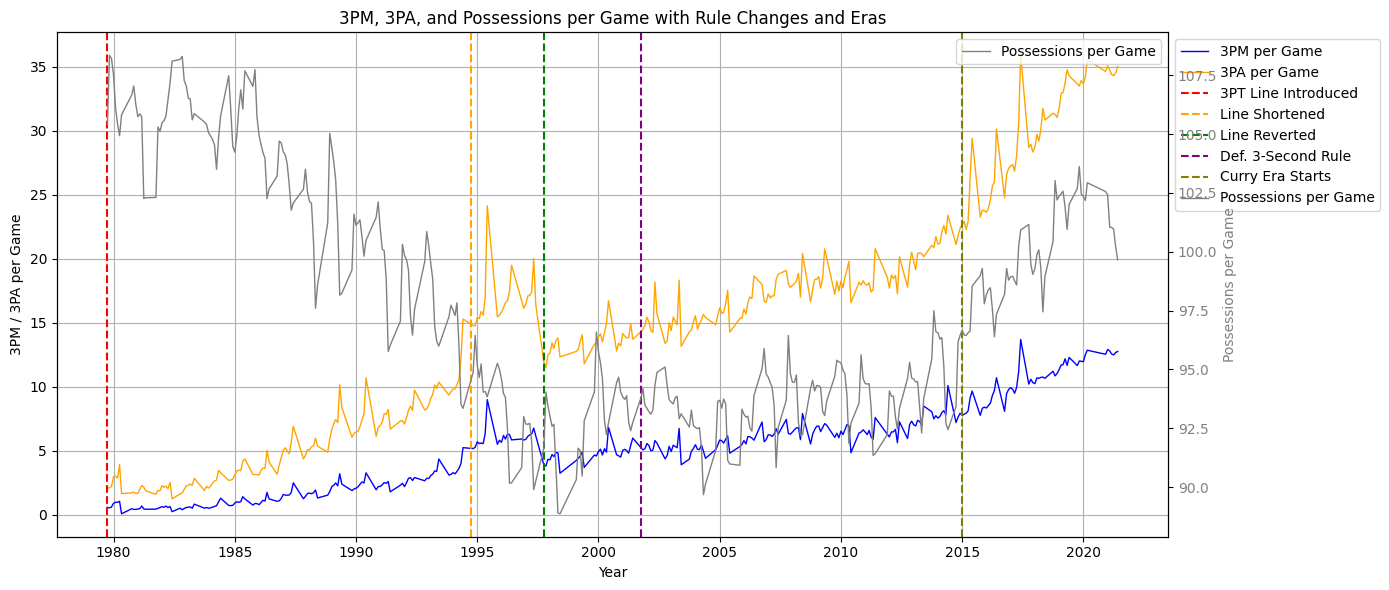

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_data = result_df[
    (result_df['off_season'] == 0) &
    (pd.to_datetime(result_df['month']) >= pd.Timestamp('1979-10-01')) &
    (result_df['possessions_per_game_smooth'] > 0)
].copy()

plot_data['month'] = pd.to_datetime(plot_data['month'])

# Start dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot 3PM and 3PA on primary y-axis
sns.lineplot(data=plot_data, x='month', y='FG3_per_game', label='3PM per Game', ax=ax1, color='blue', linewidth=1)
sns.lineplot(data=plot_data, x='month', y='FG3A_per_game', label='3PA per Game', ax=ax1, color='orange', linewidth=1)
ax1.set_ylabel('3PM / 3PA per Game', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create secondary y-axis for possessions
ax2 = ax1.twinx()
sns.lineplot(data=plot_data, x='month', y='possessions_per_game_smooth', label='Possessions per Game', ax=ax2, color='gray', linewidth=1)
ax2.set_ylabel('Possessions per Game', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Rule change / era lines
for date, color, label in [
    ('1979-10-01', 'red', '3PT Line Introduced'),
    ('1994-10-01', 'orange', 'Line Shortened'),
    ('1997-10-01', 'green', 'Line Reverted'),
    ('2001-10-01', 'purple', 'Def. 3-Second Rule'),
    ('2015-01-01', 'olive', 'Curry Era Starts')
]:
    ax1.axvline(pd.Timestamp(date), color=color, linestyle='--', label=label)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1, 1))

# Title and formatting
plt.title('3PM, 3PA, and Possessions per Game with Rule Changes and Eras')
ax1.set_xlabel('Year')
ax1.grid(True)
plt.tight_layout()
plt.show()


In [98]:
# export the data to a CSV file into the current folder
folder_path = r'C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\SS2025\Predictive Analytics\Final Exam'
output_path = os.path.join(folder_path, 'monthly_fg3_per_game_clean.csv')
result_df.to_csv(output_path, index=False)
print(f"\n✅ Done! Saved to: {output_path}")


✅ Done! Saved to: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\SS2025\Predictive Analytics\Final Exam\monthly_fg3_per_game_clean.csv
